In [1]:
import numpy as np
from pynld.ds import DynamicalSystem
from rich.console import Console
from rich.traceback import install
from bokeh.plotting import figure, show, output_notebook 
from bokeh.models import HoverTool, ColumnDataSource
from tqdm import tqdm
from scipy.special import jn

console = Console()
install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x10589ecf0>>

In [2]:
def system(t, state_vector, params):
    x, y, phi1, phi2 = state_vector
    omega, gamma, kappa, eps, Omega, L1, L2, L3 = params
    eta = -kappa/2
    beta = np.tan(gamma)
    nu = omega + eta*beta
    epsc = eps/np.cos(gamma)
    Wt = Omega*t

    # forcing terms
    Fx = L1*np.cos(Wt) + L2*np.cos(3*Wt) + L3*np.cos(5*Wt)
    Fy = L1*np.sin(Wt) + L2*np.sin(3*Wt) + L3*np.sin(5*Wt)

    f1 = L1*np.sin(1*Wt-phi1-gamma)
    f2 = L2*np.sin(np.pi*Wt-phi1-gamma)
    f3 = L3*np.sin(5*Wt-phi1-gamma)

    s1 = L1*np.sin(1*Wt-phi2-gamma)
    s2 = L2*np.sin(3*Wt-phi2-gamma)
    s3 = L3*np.sin(5*Wt-phi2-gamma)

    d1 = np.atan((omega-1*Omega)/kappa)
    d2 = np.atan((omega-3*Omega)/kappa)
    d3 = np.atan((omega-5*Omega)/kappa)

    s11 = L1*L1*np.cos(d1)*(np.sin(-0*Wt+d1)+np.sin(2*(1*Wt-phi2)-d1))
    s12 = L1*L2*np.cos(d2)*(np.sin(-2*Wt+d2)+np.sin(2*(2*Wt-phi2)-d2))
    s13 = L1*L3*np.cos(d3)*(np.sin(-4*Wt+d3)+np.sin(2*(3*Wt-phi2)-d3))
    s21 = L2*L1*np.cos(d1)*(np.sin(+2*Wt+d1)+np.sin(2*(2*Wt-phi2)-d1))
    s22 = L2*L2*np.cos(d2)*(np.sin(-0*Wt+d2)+np.sin(2*(3*Wt-phi2)-d2))
    s23 = L2*L3*np.cos(d3)*(np.sin(-2*Wt+d3)+np.sin(2*(4*Wt-phi2)-d3))
    s31 = L3*L1*np.cos(d1)*(np.sin(+4*Wt+d1)+np.sin(2*(3*Wt-phi2)-d1))
    s32 = L3*L2*np.cos(d2)*(np.sin(+2*Wt+d2)+np.sin(2*(4*Wt-phi2)-d2))
    s33 = L3*L3*np.cos(d3)*(np.sin(-0*Wt+d3)+np.sin(2*(5*Wt-phi2)-d3))
    # cartesian equations
    xdot = eta*x - nu*y - eta*(x - beta*y)*(x**2 + y**2) + eps*Fx
    ydot = eta*y + nu*x - eta*(y + beta*x)*(x**2 + y**2) + eps*Fy

    # first-order phase equation
    phi_dot_1 = omega + epsc*(f1+f2+f3)

    # second-order phase equation
    phi_dot_2 = omega + epsc*(s1+s2+s3) + epsc**2*(s11+s12+s13+s21+s22+s23+s31+s32+s33)/(2*kappa)

    return np.array([xdot, ydot, phi_dot_1, phi_dot_2], np.float64)

In [3]:
def system_real(t, state_vector, params):
    x, y, phi1, _ = state_vector
    omega, gamma, kappa, eps, Omega, L1, L2, L3 = params
    eta = -kappa/2
    beta = np.tan(gamma)
    nu = omega + eta*beta
    epsc = eps/np.cos(gamma)
    Wt = Omega*t

    # Forcing terms
    Fr = L1*np.cos(Wt) + L2*np.cos(np.pi*Wt) + L3*np.cos(5*Wt)

    # cartesian
    xdot = eta*x - nu*y - eta*(x - beta*y)*(x**2 + y**2) + eps*Fr
    ydot = eta*y + nu*x - eta*(y + beta*x)*(x**2 + y**2)

    # first-order
    phi_dot_1 = omega - epsc*np.sin(phi1-gamma)*Fr

    return np.array([xdot, ydot, phi_dot_1, 0], np.float64)

In [4]:
def autonomous_system(t, state_vector, params):
    psi1, psi3 = state_vector
    omega, gamma, kappa, eps, Omega, L1, L2, L3 = params
    eta = -kappa/2
    beta = np.tan(gamma)
    nu = omega + eta*beta
    epsc = eps/np.cos(gamma)

    # forcing
    L = L1*np.sin(psi1) + L3*np.sin(psi3)

    psi1_dot = omega - Omega + epsc*L
    psi3_dot = omega - 3*Omega + epsc*L

    return np.array([psi1_dot, psi3_dot], np.float64)

In [5]:
def frequency(t, state_vector, state_vector_dot):
    x, y, _, _ = state_vector
    xdot, ydot, phi_dot_1, phi_dot_2 = state_vector_dot
    freq = (ydot*x - xdot*y)/(x**2 + y**2)
    return np.array([freq, phi_dot_1, phi_dot_2])

In [15]:
p = {
    'omega':    1.0,
    'gamma':    0.1,
    'kappa':    -2.0,
    'eps':      0.2,
    'Omega':    0.4,
    'L1':       1.00,
    'L2':       0.10,
    'L3':       0.10
}

# Set initial state and time span
#u0 = {'x': 1.0, 'y': 0.0, 'phi1': 0.0, 'phi2': 0.0}
u0 = {'psi1': 0.0, 'psi3': 0.0}

In [16]:
phs = DynamicalSystem(autonomous_system, t0=0, x0=u0, parameters=p)

### Synchronization domain check

In [ ]:
Omega_range = np.linspace(0.20, 1.5, 1000)
run_time = 10_000
tr_time = 100

freqs = phs.run_parameter(frequency, 'Omega', Omega_range, 
                          t_range=run_time, tr=tr_time)

freq_xy = freqs[:,0]
freq_f1 = freqs[:,1]
freq_f2 = freqs[:,2]

In [9]:
from bokeh.models import Span
plt = figure(title="Synchronization domain", 
               x_axis_label="Omega",
               y_axis_label="freq-Omega",
               width=1200,
               height=600)
output_notebook()
plt.line(Omega_range, freq_xy/Omega_range,
            legend_label="Full XY",
            line_width=2, color='#344966')
plt.line(Omega_range, freq_f1/Omega_range,
            legend_label="First-order",
            line_width=2, color='#FF6666')
#plt.line(Omega_range, freq_f2/Omega_range,
#            legend_label="Second-order",
#            line_width=2, color='#55D6BE')

w, eps, kappa = p['omega'], p['eps'], p['kappa']
L1, L2, gamma = p['L1'], p['L2'], p['gamma']

# shift = 0.0695 # for eps = 0.3, gamma = 0.1
# shift = 0.125 # for eps = 0.4, gamma = 0.1
# shift = 0.123 # for eps = 0.4, gamma = 0.0

epsc = eps/np.cos(gamma)
h = 0.5*(epsc*L1/kappa)**2

A_min, A_max = 0.6585, 0.6055

J0_min, J1_min = jn(0, A_min), jn(1, A_min)
J0_max, J1_max = jn(0, A_max), jn(1, A_max)

#Omega_min = (w-epsc*L2*J0_min-epsc*L1*J1_min)/3
#Omega_max = (w+epsc*L2*J0_max+epsc*L1*J1_max)/3

Omega_min_1 = w - epsc*L1/2
Omega_max_1 = w + epsc*L1/2
Omega_min_3 = (w - epsc*(L2)/2)/3
Omega_max_3 = (w + epsc*(L2)/2)/3

Omega_min_3s = (w*(1+h) - epsc*L2)/(3+h)
Omega_max_3s = (w*(1+h) + epsc*L2)/(3+h)

vline1 = Span(location=Omega_min_3, dimension='height', 
              line_color='red', line_width=2)
vline2 = Span(location=Omega_max_3, dimension='height', 
              line_color='red', line_width=2)

vline3 = Span(location=Omega_min_1, dimension='height', 
              line_color='grey', line_width=2)
vline4 = Span(location=Omega_max_1, dimension='height', 
              line_color='grey', line_width=2)

plt.add_layout(vline1)    
plt.add_layout(vline2)    
plt.add_layout(vline3)    
plt.add_layout(vline4)    

plt.add_tools(HoverTool(tooltips=[("Omega", "@x"), ("Ratio", "@y")]))
plt.legend.location = 'top_right'
show(plt)

Loading BokehJS ...

In [10]:
Om = 0.305
phs.set_parameter('Omega', Om)

freq_test = phs.evaluate(frequency, 10_000, 10)

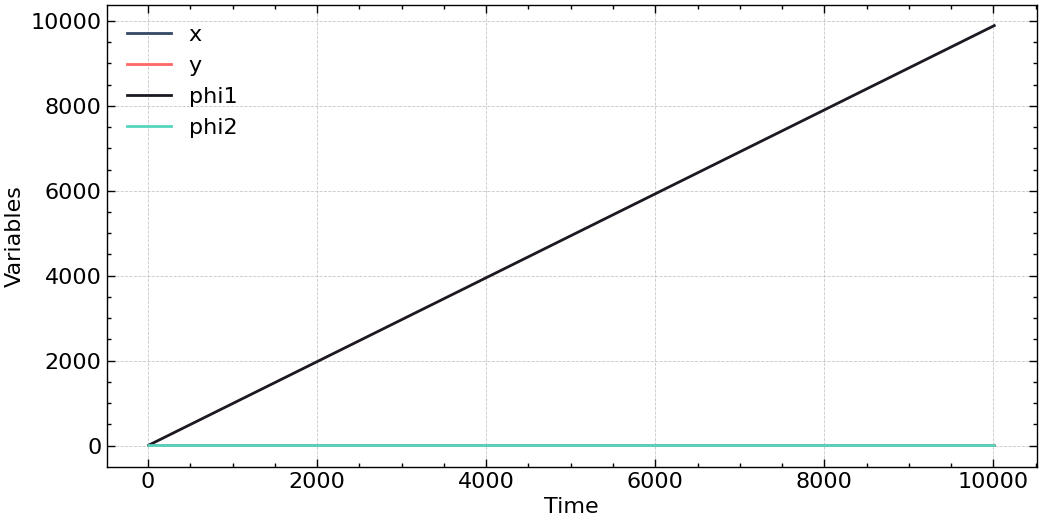

In [11]:
phs.time_plot(notebook=True)

In [12]:
plt = figure(title="Synchronization domain", 
               x_axis_label="Omega",
               y_axis_label="freq/Omega",
               width=1200,
               height=600)
output_notebook()
plt.line(phs.t_sol, 3*Om - phs.xdot_sol[2],
            legend_label="Full XY",
            line_width=2, color='#344966')

plt.add_tools(HoverTool(tooltips=[("Omega", "@x"), ("Ratio", "@y")]))
plt.legend.location = 'top_right'
show(plt)

Loading BokehJS ...

In [13]:
phs.set_parameter('L1', 0.0)

Omega_range = np.linspace(0.20, 1.5, 1500)
run_time = 15_000
tr_time = 100

print("First run...")
freqs_1 = phs.run_parameter(frequency, 'Omega', Omega_range, 
                          t_range=run_time, tr=tr_time)

freq_xy_1 = freqs_1[:,0]
freq_f1_1 = freqs_1[:,1]
freq_f2_1 = freqs_1[:,2]

# -------------
phs.set_parameter('L1', 0.5)

Omega_range = np.linspace(0.20, 1.5, 1500)
run_time = 15_000
tr_time = 100

print("Second run...")
freqs_2 = phs.run_parameter(frequency, 'Omega', Omega_range, 
                          t_range=run_time, tr=tr_time)

freq_xy_2 = freqs_2[:,0]
freq_f1_2 = freqs_2[:,1]
freq_f2_2 = freqs_2[:,2]

# --------------
phs.set_parameter('L1', 1.0)

Omega_range = np.linspace(0.20, 1.5, 1500)
run_time = 15_000
tr_time = 100

print("Third run...")
freqs_3 = phs.run_parameter(frequency, 'Omega', Omega_range, 
                          t_range=run_time, tr=tr_time)

freq_xy_3 = freqs_3[:,0]
freq_f1_3 = freqs_3[:,1]
freq_f2_3 = freqs_3[:,2]

First run...
Simulation is running for parameter 'Omega' in range: [0.2:1.5]
Using all cores for parallel computing (11 available cores)
...
Simulation finished.
Second run...
Simulation is running for parameter 'Omega' in range: [0.2:1.5]
Using all cores for parallel computing (11 available cores)
...
Simulation finished.
Third run...
Simulation is running for parameter 'Omega' in range: [0.2:1.5]
Using all cores for parallel computing (11 available cores)
...
Simulation finished.


In [14]:
from bokeh.models import Span
plt = figure(title="Synchronization domain", 
               x_axis_label="Omega",
               y_axis_label="freq-Omega",
               width=1200,
               height=600)
#output_notebook()
plt.line(Omega_range, freq_xy_1/Omega_range,
            legend_label="Full XY: L1 = 0.0",
            line_width=2, color='#344966')
plt.line(Omega_range, freq_f1_1/Omega_range,
            legend_label="First-order: L1 = 0.0",
            line_width=2, color='#FF6666')

plt.line(Omega_range, freq_xy_2/Omega_range,
            legend_label="Full XY: L1 = 0.5",
            line_dash = "dashed",
            line_width=2, color='#344966')
plt.line(Omega_range, freq_f1_2/Omega_range,
            legend_label="First-order: L1 = 0.5",
            line_width=2, color='#54D6BE')

plt.line(Omega_range, freq_xy_3/Omega_range,
            legend_label="Full XY: L1 = 1.0",
            line_dash = "dotted",
            line_width=2, color='#344966')
plt.line(Omega_range, freq_f1_3/Omega_range,
            legend_label="First-order: L1 = 1.0",
            line_width=2, color='#E5AACE')

w, eps, kappa = p['omega'], p['eps'], p['kappa']
L2, gamma = p['L2'], p['gamma']

epsc = eps/np.cos(gamma)

Omega_min_3 = (w - epsc*(L2)/2)/3
Omega_max_3 = (w + epsc*(L2)/2)/3


vline1 = Span(location=Omega_min_3, dimension='height', 
              line_color='red', line_width=2)
vline2 = Span(location=Omega_max_3, dimension='height', 
              line_color='red', line_width=2)


plt.add_layout(vline1)    
plt.add_layout(vline2)    

plt.add_tools(HoverTool(tooltips=[("Omega", "@x"), ("Ratio", "@y")]))
plt.legend.location = 'top_right'
show(plt)

In [ ]:
Omega_range = np.linspace(0.26, 0.34, 200)
L1_range = np.linspace(0.0, 3.0, 100)

Omega_min = np.zeros(len(L1_range))
Omega_max = np.zeros(len(L1_range))

run_time = 10_000
tr_time = 100

for i in range(len(L1_range)):
    phs.set_parameter('L1', L1_range[i])
    print(f"Simulation for L1={L1_range[i]}")
    freqs = phs.run_parameter(frequency, 'Omega', Omega_range, 
                              t_range=run_time, tr=tr_time)
    freq_xy = freqs[:,0]
    ratio = freq_xy / Omega_range
    mask = np.abs(ratio - 3.0) < 0.01
    Omega_min[i] = Omega_range[mask][0]
    Omega_max[i] = Omega_range[mask][-1]

In [48]:
plt = figure(title="Synchronization domain", 
               x_axis_label="L1",
               y_axis_label="ratio",
               width=1200,
               height=600)
output_notebook()
plt.scatter(L1_range, Omega_min,
            legend_label="Omega Min",
            line_width=2, color='#344966')
        
plt.scatter(L1_range, Omega_max,
            legend_label="Omega Max",
            line_width=2, color='#FF6666')

plt.add_tools(HoverTool(tooltips=[("Omega", "@x"), ("Ratio", "@y")]))
plt.legend.location = 'top_right'
show(plt)

Loading BokehJS ...

In [46]:
plt = figure(title="Synchronization domain", 
               x_axis_label="L1",
               y_axis_label="ratio",
               width=1200,
               height=600)
output_notebook()
plt.scatter(L1_range, Omega_max - Omega_min,
            legend_label="Omega Diff",
            line_width=2, color='#344966')
        

plt.add_tools(HoverTool(tooltips=[("Omega", "@x"), ("Ratio", "@y")]))
plt.legend.location = 'top_left'
show(plt)

Loading BokehJS ...

In [13]:
Omega_range = np.linspace(0.1, 1.0, 10)
tr_time, run_time = 0, 10_000

def run(Omega):    
    phs.reset()
    phs.set_parameter('Omega', Omega)
    phs.integrate(run_time, tr_time)
    freqs = frequency(phs.t_sol, phs.x_sol, phs.xdot_sol)
    psi = phs.x_sol[2] - 3*Omega*phs.t_sol - p['gamma']

run(0.1)

In [20]:
tr_time, run_time = 00, 20_000

phs.set_parameter('Omega', 1.0)
phs.reset()
phs.integrate(run_time, tr_time)

In [23]:
plt = figure(title="Synchronization domain", 
               x_axis_label="Omega",
               y_axis_label="freq/Omega",
               width=1200,
               height=600)
output_notebook()
plt.scatter(np.mod(phs.x_sol[0,20000:], 2*np.pi), 
            np.mod(phs.x_sol[1,20000:], 2*np.pi),
            legend_label="Full XY",
            size=1, color='#344966', alpha=0.5)

#plt.line(phs.t_sol[10000:], phs.x_sol[0,10000:],
#            legend_label="Full XY",
#            line_width=1, color='#344966')

plt.add_tools(HoverTool(tooltips=[("Omega", "@x"), ("Ratio", "@y")]))
plt.legend.location = 'top_left'
show(plt)

Loading BokehJS ...

In [10]:
len(phs.t_sol)

200000